# Cross-Modality MRI Synthesis with CycleGANs for Vestibular Schwannoma Segmentation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/GitHub/Cross-Modality-MRI-Synthesis-with-CycleGANs

/content/drive/MyDrive/GitHub/MRI-Contrast-Transformation


## Import Libraries

In [4]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
import torch.multiprocessing as mp

import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Resized, Rotate90d, Lambdad, NormalizeIntensityd, ToTensord
)

import matplotlib.pyplot as plt
import numpy as np

import itertools
import functools

import os
import csv

## Data Loader

**Dataset**: Vestibular-Schwannoma-SEG | Segmentation of Vestibular Schwannoma from Magnetic Resonance Imaging: An Open Annotated Dataset and Baseline Algorithm


**Citation**: Shapey, J., Kujawa, A., Dorent, R., Wang, G., Bisdas, S., Dimitriadis, A., Grishchuck, D., Paddick, I., Kitchen, N., Bradford, R., Saeed, S., Ourselin, S., & Vercauteren, T. (2021). Segmentation of Vestibular Schwannoma from Magnetic Resonance Imaging: An Open Annotated Dataset and Baseline Algorithm (version 2) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/TCIA.9YTJ-5Q73

In [1]:
# Configuration Parameters Class
class Config:
    def __init__(self, data_root='./data'):
        self.data_root = data_root
        self.split_csv = os.path.join(self.data_root, 'split_TCIA.csv')
        self.train_transforms, self.val_transforms = self.get_transforms()

    def get_transforms(self):
        # Define transformation pipeline for 2D slice extraction
        transforms = Compose([
            LoadImaged(keys=["A", "B"]),
            EnsureChannelFirstd(keys=["A", "B"]),
            Orientationd(keys=["A", "B"], axcodes="RAS"),
            Rotate90d(keys=["A", "B"], k=3),
            lambda x: {key: val[:, :, :, 32] for key, val in x.items()},  # Select the middle slice along the third dimension
            Resized(keys=["A", "B"], spatial_size=(384, 384)),
            NormalizeIntensityd(keys=["A", "B"]),
            ToTensord(keys=["A", "B"]),
        ])
        return transforms, transforms

In [16]:
# DataLoader Class
class MRIDataset(Dataset):
    def __init__(self, config, mode='train'):
        self.config = config
        self.mode = mode
        self.files = self.load_files()
        if not self.files:
            raise ValueError(f"No data found for mode {self.mode}. Check the split_csv and data directory.")

    def load_files(self):
        files = []
        with open(self.config.split_csv, mode='r') as csvfile:
            csvReader = csv.reader(csvfile)
            for row in csvReader:
                if row[1] == self.mode:
                    base_path = os.path.join(self.config.data_root, f'{row[0]}')
                    files.append({
                        "A": os.path.join(base_path, 'vs_gk_t1_refT1.nii.gz'),
                        "B": os.path.join(base_path, 'vs_gk_t2_refT2.nii.gz')
                    })
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = self.files[idx]
        data = self.config.train_transforms(data)
        return data

## Display Function for 2D Images

In [17]:
def show_images(t1_image, t2_image):
    print(t1_image.shape)
    print(t2_image.shape)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(t1_image.squeeze(), cmap='gray', aspect='equal')
    ax[0].set_title("T1 Image")
    ax[1].imshow(t2_image.squeeze(), cmap='gray', aspect='equal')
    ax[1].set_title("T2 Image")

    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

torch.Size([1, 1, 384, 384])
torch.Size([1, 1, 384, 384])


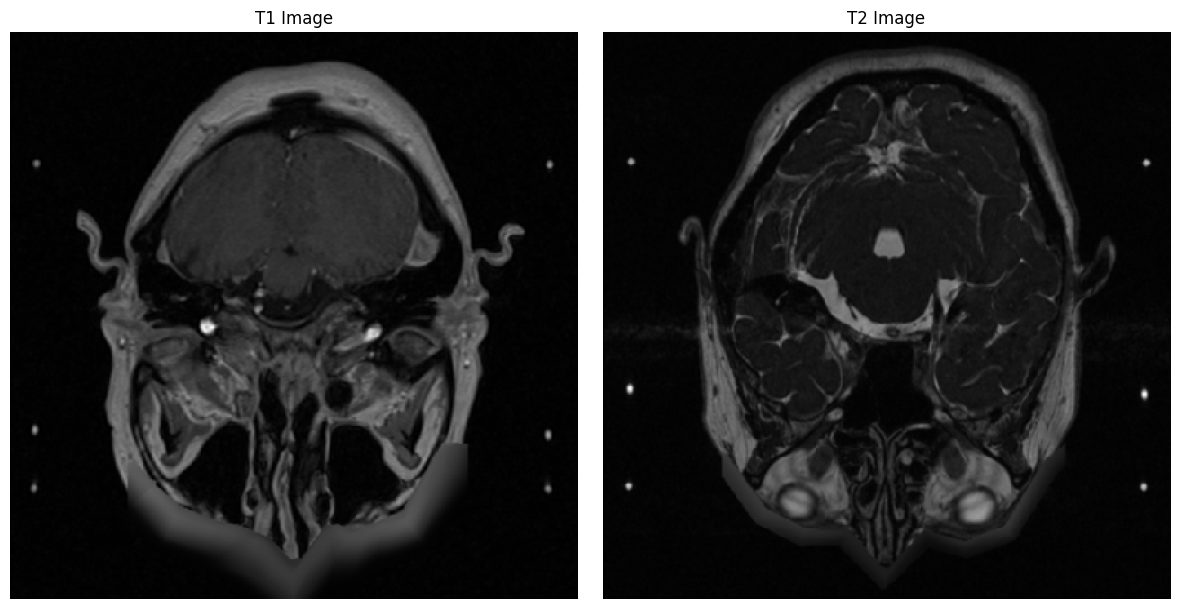

In [102]:
config = Config(data_root='./data')
train_dataset = MRIDataset(config, mode='train')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
validation_dataset = MRIDataset(config, mode='validation')
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)


for data_sample in train_loader:
    t1_image = data_sample['A'].to('cpu')
    t2_image = data_sample['B'].to('cpu')
    show_images(t1_image, t2_image)
    break  # Display only one sample for demonstration purposes

In [19]:
# Network Initialization Functions
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and ('Conv' in classname):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm' in classname:
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    if torch.cuda.is_available() and gpu_ids:
        net.to(gpu_ids[0])
        net = nn.DataParallel(net, gpu_ids)
    init_weights(net, init_type, init_gain)
    return net

## Generator and Discriminator

In [115]:
# Network Initialization and Classes for 2D
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.InstanceNorm2d, use_dropout=False, use_bias=True):
        super(ResnetBlock, self).__init__()
        padding = nn.ReflectionPad2d(1) if padding_type == 'reflect' else nn.ReplicationPad2d(1)
        self.conv_block = nn.Sequential(
            padding, nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias), norm_layer(dim), nn.ReLU(True),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            padding, nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias), norm_layer(dim)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=32, n_blocks=6, norm_layer=nn.InstanceNorm2d, use_dropout=False):
        super(ResnetGenerator, self).__init__()
        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0), norm_layer(ngf), nn.ReLU(True)]
        # Downsampling
        for i in range(2):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      norm_layer(ngf * mult * 2), nn.ReLU(True)]
        # Residual blocks
        mult = 2 ** 2
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, norm_layer=norm_layer, use_dropout=use_dropout)]
        # Upsampling
        for i in range(2):
            mult = 2 ** (2 - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                      norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=32, n_layers=2, norm_layer=nn.InstanceNorm2d):
        super(NLayerDiscriminator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 4)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

## GAN Loss Class Definition

In [116]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='lsgan', target_real_label=1.0, target_fake_label=0.0):
        """Initialize GANLoss with the specified mode and target labels."""
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()

    def get_target_tensor(self, prediction, target_is_real):
        """Generate a target tensor based on whether the target is real or fake."""
        target_tensor = self.real_label if target_is_real else self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate the loss for a prediction against the real or fake target."""
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        return self.loss(prediction, target_tensor.to(prediction.device))

## CycleGAN Model Class Definition

In [117]:
class CycleGANModel(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, ndf=64, lr=0.0002, beta1=0.5, lmbda=10, gpu_ids=[]):
        super(CycleGANModel, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.ndf = ndf
        self.lr = lr
        self.beta1 = beta1
        self.lmbda = lmbda  # Ensure lambda is correctly initialized as an instance variable
        self.gpu_ids = gpu_ids
        self.device = torch.device('cuda:{}'.format(gpu_ids[0]) if gpu_ids else 'cpu')

        # Initialize network modules
        self.netG_A2B = init_net(ResnetGenerator(input_nc, output_nc, ngf, norm_layer=nn.InstanceNorm2d), 'normal', 0.02, gpu_ids)
        self.netG_B2A = init_net(ResnetGenerator(output_nc, input_nc, ngf, norm_layer=nn.InstanceNorm2d), 'normal', 0.02, gpu_ids)
        self.netD_A = init_net(NLayerDiscriminator(output_nc, ndf), 'normal', 0.02, gpu_ids)
        self.netD_B = init_net(NLayerDiscriminator(input_nc, ndf), 'normal', 0.02, gpu_ids)

        # Setup loss functions and optimizers
        self.setup_loss_and_optimizers()

    def setup_loss_and_optimizers(self):
        self.criterionGAN = GANLoss().to(self.device)
        self.criterionCycle = nn.L1Loss().to(self.device)
        self.criterionIdt = nn.L1Loss().to(self.device)
        self.optimizer_G = optim.Adam(itertools.chain(self.netG_A2B.parameters(), self.netG_B2A.parameters()), lr=self.lr, betas=(self.beta1, 0.999))
        self.optimizer_D = optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=self.lr, betas=(self.beta1, 0.999))
        self.scheduler_G = torch.optim.lr_scheduler.ExponentialLR(self.optimizer_G, gamma=0.95)
        self.scheduler_D = torch.optim.lr_scheduler.ExponentialLR(self.optimizer_D, gamma=0.95)

    def set_requires_grad(self, nets, requires_grad=False):
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    def set_input(self, input):
        """Sets the input data for the model."""
        self.real_A = input['A'].to(self.device)
        self.real_B = input['B'].to(self.device)

    def forward(self, real_A, real_B):
        # Forward operations...
        self.fake_B = self.netG_A2B(real_A)
        self.rec_A = self.netG_B2A(self.fake_B)
        self.fake_A = self.netG_B2A(real_B)
        self.rec_B = self.netG_A2B(self.fake_A)
        print("### Before backward_G ###")
        print("ID of fake_A:", id(self.fake_A))
        print("Value of fake_A (sample):", self.fake_A[:2])
        print("ID of fake_B:", id(self.fake_B))
        print("Value of fake_B (sample):", self.fake_B[:2])
        return self.fake_A, self.fake_B, self.rec_A, self.rec_B

    def compute_losses(self):
        """Computes losses for the model using internal state."""
        # Generate fake images and reconstructions
        fake_B = self.netG_A2B(self.real_A)
        rec_A = self.netG_B2A(fake_B)
        fake_A = self.netG_B2A(self.real_B)
        rec_B = self.netG_A2B(fake_A)

        # Compute losses for the generator
        loss_G_A = self.criterionGAN(self.netD_A(fake_B), True)
        loss_G_B = self.criterionGAN(self.netD_B(fake_A), True)
        loss_cycle_A = self.criterionCycle(rec_A, self.real_A) * self.lmbda
        loss_cycle_B = self.criterionCycle(rec_B, self.real_B) * self.lmbda
        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B

        # Compute combined losses for the discriminators
        loss_D = self.backward_discriminator(self.netD_A, self.real_B, fake_B) + \
                self.backward_discriminator(self.netD_B, self.real_A, fake_A)

        return loss_G, loss_D

    def backward_discriminator(self, netD, real, fake):
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        return (loss_D_real + loss_D_fake) * 0.5

    def backward_G(self):
        lambda_idt, lambda_A, lambda_B = 0.5, 10.0, 10.0
        self.loss_idt_A = self.criterionIdt(self.netG_A2B(self.real_B), self.real_B) * lambda_B * lambda_idt
        self.loss_idt_B = self.criterionIdt(self.netG_B2A(self.real_A), self.real_A) * lambda_A * lambda_idt
        self.loss_G = sum([self.criterionGAN(netD(fake), True) for netD, fake in zip([self.netD_A, self.netD_B], [self.fake_B, self.fake_A])])
        self.loss_G += sum([self.criterionCycle(rec, real) * lam for rec, real, lam in zip([self.rec_A, self.rec_B], [self.real_A, self.real_B], [lambda_A, lambda_B])])
        self.loss_G += self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()
        # Debugging output after backward_G
        # print("### After backward_G ###")
        # print("ID of fake_A:", id(self.fake_A))
        # print("Value of fake_A (sample):", self.fake_A[:2])
        # print("ID of fake_B:", id(self.fake_B))
        # print("Value of fake_B (sample):", self.fake_B[:2])

    def optimize_parameters(self):
        # Perform forward pass outside of optimization if not already done
        self.forward()
        # print("### Before forward call ###")
        # print("ID of fake_A:", id(self.fake_A))
        # print("Value of fake_A (sample):", self.fake_A[:2])
        # print("ID of fake_B:", id(self.fake_B))
        # print("Value of fake_B (sample):", self.fake_B[:2])

        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()

        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()

        # print("### Before discriminator updates ###")
        # print("ID of fake_A:", id(self.fake_A))
        # print("Value of fake_A (sample):", self.fake_A[:2])
        # print("ID of fake_B:", id(self.fake_B))
        # print("Value of fake_B (sample):", self.fake_B[:2])

        self.backward_discriminator(self.netD_A, self.real_B, self.fake_B)
        self.backward_discriminator(self.netD_B, self.real_A, self.fake_A)
        self.optimizer_D.step()

        self.scheduler_G.step()
        self.scheduler_D.step()

## Saving and Loading Functions

In [131]:
import glob

checkpoint_dir = './checkpoints'

def save_model(model, epoch, optimizer_G, optimizer_D, scheduler_G, scheduler_D, scaler):
    file_path = os.path.join(checkpoint_dir, f"cycleGAN_checkpoint_{epoch}.pth")
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'scheduler_G_state_dict': scheduler_G.state_dict(),
        'scheduler_D_state_dict': scheduler_D.state_dict()
    }, file_path)
    print(f"Model saved for Epoch {epoch+1} at {file_path}")

def load_model(model, optimizer_G, optimizer_D, scaler, file_path, device):
    checkpoint = torch.load(file_path, map_location=device)  # Load to the specified device
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)  # Ensure model is on the right device
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    if 'scaler_state_dict' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"Model loaded from {file_path}")

def load_latest_checkpoint(model, optimizer_G, optimizer_D, scaler, device):
    checkpoint_dir = './checkpoints'
    list_of_files = glob.glob(f"{checkpoint_dir}/cycleGAN_checkpoint_*.pth")  # Ensure correct path
    if not list_of_files:
        raise FileNotFoundError("No checkpoint files found.")
    latest_file = max(list_of_files, key=os.path.getctime)
    load_model(model, optimizer_G, optimizer_D, scaler, latest_file, device)
    return int(latest_file.split('_')[-1].split('.')[0])  # Extract epoch number from file name


## Evaluate model

In [121]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss_G = 0
    total_loss_D = 0
    total_psnr = 0
    total_ssim = 0
    count = 0

    with torch.no_grad():
        for data in dataloader:
            model.set_input(data)
            loss_G, loss_D = model.calculate_loss()  # Ensure you have this method in your model
            total_loss_G += loss_G.item()
            total_loss_D += loss_D.item()

            # Extract tensor to numpy for PSNR and SSIM calculation
            real_A = model.real_A.detach().cpu().numpy().squeeze()
            fake_B = model.fake_B.detach().cpu().numpy().squeeze()
            real_B = model.real_B.detach().cpu().numpy().squeeze()
            fake_A = model.fake_A.detach().cpu().numpy().squeeze()

            # Compute PSNR and SSIM for both transformations
            current_psnr_AB = psnr(real_A, fake_B, data_range=fake_B.max() - fake_B.min())
            current_ssim_AB = ssim(real_A, fake_B, data_range=fake_B.max() - fake_B.min())
            current_psnr_BA = psnr(real_B, fake_A, data_range=fake_A.max() - fake_A.min())
            current_ssim_BA = ssim(real_B, fake_A, data_range=fake_A.max() - fake_A.min())

            total_psnr += (current_psnr_AB + current_psnr_BA)
            total_ssim += (current_ssim_AB + current_ssim_BA)
            count += 2  # Counting both transformations per batch

    average_loss_G = total_loss_G / len(dataloader)
    average_loss_D = total_loss_D / len(dataloader)
    average_psnr = total_psnr / count
    average_ssim = total_ssim / count
    print(f"Evaluation Average Loss - G: {average_loss_G}, D: {average_loss_D}")
    print(f"Average PSNR: {average_psnr}, Average SSIM: {average_ssim}")

    model.train()  # Switch back to training mode after evaluation

    return average_loss_G, average_loss_D, average_psnr, average_ssim


## Configuration for the model

In [122]:
model_config = {
    'input_nc': 1,  # Number of input channels
    'output_nc': 1,  # Number of output channels
    'ngf': 64,       # Number of generator filters
    'ndf': 64,       # Number of discriminator filters
    'lr': 0.0002,    # Learning rate
    'beta1': 0.5,    # Beta1 hyperparameter for Adam optimizers
    'lmbda': 10,     # Lambda for cycle consistency loss
    'gpu_ids': [0] if torch.cuda.is_available() else []  # GPU configuration
}

# Initialize the model
model = CycleGANModel(**model_config)

# Optimizers Configuration
optimizer_G = optim.Adam(itertools.chain(model.netG_A2B.parameters(), model.netG_B2A.parameters()), lr=model_config['lr'], betas=(model_config['beta1'], 0.999))
optimizer_D = optim.Adam(itertools.chain(model.netD_A.parameters(), model.netD_B.parameters()), lr=model_config['lr'], betas=(model_config['beta1'], 0.999))

# Schedulers Configuration
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=100, gamma=0.1)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=100, gamma=0.1)


# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CycleGANModel(
  (netG_A2B): DataParallel(
    (module): ResnetGenerator(
      (model): Sequential(
        (0): ReflectionPad2d((3, 3, 3, 3))
        (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
        (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (9): ReLU(inplace=True)
        (10): ResnetBlock(
          (conv_block): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
            (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, 

## Training Loop

In [138]:
def train_one_epoch(model, dataloader, device,
                    optimizer_G, optimizer_D, scheduler_G, scheduler_D,
                    scaler, accumulation_steps=4):
    model.train()
    total_loss = {'G': 0, 'D': 0}
    for i, data in enumerate(dataloader):
        model.set_input(data)
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        with autocast():
            loss_G, loss_D = model.compute_losses()

        # Scale and backward the generator and discriminator losses
        scaler.scale(loss_G).backward(retain_graph=True)
        scaler.scale(loss_D).backward()

        # Step optimizers
        scaler.step(optimizer_G)
        scaler.step(optimizer_D)
        scaler.update()

        # Reset gradients
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        # Step schedulers after optimizer step
        scheduler_G.step()
        scheduler_D.step()

        total_loss['G'] += loss_G.item()
        total_loss['D'] += loss_D.item()

        # Printing running loss stats
        if (i + 1) % accumulation_steps == 0:
            print(f"Batch {i+1}/{len(dataloader)}, Loss G: {total_loss['G']/(i+1)}, Loss D: {total_loss['D']/(i+1)}")

    num_batches = len(dataloader)
    avg_loss_epoch = {k: v / num_batches for k, v in total_loss.items()}
    print(f"Completed Epoch: Avg Loss: {avg_loss_epoch}")

In [129]:
num_epochs = 10
print("Starting training with the following configuration:", model_config)
scaler = GradScaler()  # Create a GradScaler instance
for epoch in range(num_epochs):
    print(f"Starting Epoch {epoch+1}/{num_epochs}")
    try:
        train_one_epoch(model, train_loader, device, optimizer_G, optimizer_D,
                        scheduler_G, scheduler_D, scaler, accumulation_steps=4)

        if epoch % 2 == 0 or epoch == num_epochs - 1:
            save_model(model, epoch, optimizer_G, optimizer_D,
                       scheduler_G, scheduler_D, scaler)  # Pass scaler to save_model
            print(f"Model saved for Epoch {epoch+1}")
            # Optional: Evaluate model performance
            if validation_loader is not None:
                avg_loss_G, avg_loss_D, avg_psnr, avg_ssim = evaluate_model(model, validation_loader, device)
                print(f"Evaluation completed for Epoch {epoch}: Avg Loss G: {avg_loss_G}, Avg Loss D: {avg_loss_D}, Avg PSNR: {avg_psnr}, Avg SSIM: {avg_ssim}")

    except Exception as e:
        print(f"Error during training at Epoch {epoch+1}: {e}")
        break  # Optionally handle exceptions or continue as needed

print("Training completed.")

Starting training with the following configuration: {'input_nc': 1, 'output_nc': 1, 'ngf': 64, 'ndf': 64, 'lr': 0.0002, 'beta1': 0.5, 'lmbda': 10, 'gpu_ids': [0]}
Starting Epoch 1/10
Batch 4/78, Loss G: 5.138654470443726, Loss D: 0.6369300186634064
Batch 8/78, Loss G: 5.165927290916443, Loss D: 0.6431244909763336
Batch 12/78, Loss G: 5.147255818049113, Loss D: 0.6376876930395762
Batch 16/78, Loss G: 5.072488188743591, Loss D: 0.6337578445672989
Batch 20/78, Loss G: 5.018247318267822, Loss D: 0.6321711331605911
Batch 24/78, Loss G: 4.97639673948288, Loss D: 0.6323787296811739
Batch 28/78, Loss G: 4.975993837629046, Loss D: 0.6307629985468728
Batch 32/78, Loss G: 4.955348968505859, Loss D: 0.6300530321896076
Batch 36/78, Loss G: 4.928773495886061, Loss D: 0.6306264963414934
Batch 40/78, Loss G: 4.9188068270683285, Loss D: 0.6312701612710953
Batch 44/78, Loss G: 4.890133413401517, Loss D: 0.6308126774701205
Batch 48/78, Loss G: 4.8894056379795074, Loss D: 0.6303316416839758
Batch 52/78, L

## Loading the model for resuming training or evaluation

In [132]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CycleGANModel(**model_config)
model.to(device)

# Initialize or load checkpoint as needed
try:
    epoch_start = load_latest_checkpoint(model, optimizer_G, optimizer_D, scaler, device)
    print(f"Resuming training from epoch {epoch_start + 1}")
except Exception as e:
    epoch_start = 0  # Start from the beginning if loading fails
    print(f"Failed to load the latest checkpoint: {e}. Starting training from epoch 1.")

Model loaded from ./checkpoints/cycleGAN_checkpoint_9.pth
Resuming training from epoch 10


## Resume Training

In [137]:
# Define the number of additional epochs to train
additional_epochs = 5
total_epochs = epoch_start + additional_epochs

# Continue the training loop
for epoch in range(epoch_start + 1, total_epochs + 1):
    print(f"Starting Epoch {epoch}/{total_epochs}")
    try:
        train_one_epoch(model, train_loader, device,
                        optimizer_G, optimizer_D, scheduler_G, scheduler_D,
                        scaler, accumulation_steps=4)  # Include scaler here

        if epoch % 2 == 0 or epoch == total_epochs:
            save_model(model, epoch, optimizer_G, optimizer_D, scheduler_G, scheduler_D, scaler)  # Pass scaler to save function if needed
            print(f"Model saved for Epoch {epoch}")
            # Optional: Evaluate model performance
            if validation_loader is not None:
                avg_loss_G, avg_loss_D, avg_psnr, avg_ssim = evaluate_model(model, validation_loader, device)
                print(f"Evaluation completed for Epoch {epoch}: Avg Loss G: {avg_loss_G}, Avg Loss D: {avg_loss_D}, Avg PSNR: {avg_psnr}, Avg SSIM: {avg_ssim}")

    except Exception as e:
        print(f"Error during training at Epoch {epoch}: {e}")
        break  # Optionally handle exceptions or continue as needed

print("Extended training completed.")

Starting Epoch 10/14
Error during training at Epoch 10: No inf checks were recorded for this optimizer.
Extended training completed.


## Visualization

In [ ]:
def visualize_translation(real_A, fake_B, real_B, fake_A, batch_idx):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax[0, 0].imshow(real_A.detach().cpu().squeeze(), cmap='gray')
    ax[0, 1].imshow(fake_B.detach().cpu().squeeze(), cmap='gray')
    ax[1, 0].imshow(real_B.detach().cpu().squeeze(), cmap='gray')
    ax[1, 1].imshow(fake_A.detach().cpu().squeeze(), cmap='gray')
    ax[0, 0].set_title("Real A")
    ax[0, 1].set_title("Fake B")
    ax[1, 0].set_title("Real B")
    ax[1, 1].set_title("Fake A")
    for axes in ax.flat:
        axes.axis('off')
    plt.tight_layout()
    plt.savefig(f'outputs/visualization_{batch_idx}.png')
    plt.show()

def evaluate_and_visualize(model, dataloader, device):
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            model.set_input(data)  # Set model input
            model.forward()  # Perform forward pass

            # Assuming model.forward() or another method populates these attributes
            real_A = model.real_A
            fake_B = model.fake_B
            real_B = model.real_B
            fake_A = model.fake_A

            if i % 10 == 0:  # Visualize every 10 batches
                visualize_translation(real_A, fake_B, real_B, fake_A, i)

            if i == 20:  # Stop after 20 batches for demonstration
                break

# Assuming 'device' is already defined and the model is loaded
# Assuming 'validation_loader' is a DataLoader object for your validation dataset
evaluate_and_visualize(model, validation_loader, device)
